Housekeeping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

In [3]:
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)

In [4]:
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

In [5]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

<a id='index'></a>


## Quantile regressions for tenure

### Women

Jump to
 - [Men](#urgh)
 --------------
 
 Split tables

In [6]:
path = './results/'
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]

for period in time_periods:
    file_split('sqtreg_mothers_45_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_mothers_0k_45_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_fathers_45_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_fathers_0k_45_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

In [16]:
path = './results/'
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
T = len(time_periods)

for period in range(1,T+1):
    file_split('sqtreg_mothers_3035_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_mothers_0k_3035_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_fathers_3035_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")
    file_split('sqtreg_fathers_0k_3035_{}.log'.format(period),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

In [8]:
descrip_stats = pd.read_stata('parents_dataset_spain.dta')

Read tables for women

In [17]:
# tab_moms_45_25 = {}
# tab_moms_45_50 = {}
# tab_moms_45_75 = {}

# tab_moms_45_25_0k = {}
# tab_moms_45_50_0k = {}
# tab_moms_45_75_0k = {}

# for period in time_periods:
#     tab_moms_45_25[period] = read_table(path+'sqtreg_mothers_45_{}_1.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
#     tab_moms_45_50[period] = read_table(path+'sqtreg_mothers_45_{}_2.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
#     tab_moms_45_75[period] = read_table(path+'sqtreg_mothers_45_{}_3.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
#     tab_moms_45_25_0k[period] = read_table(path+'sqtreg_mothers_0k_45_{}_1.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
#     tab_moms_45_50_0k[period] = read_table(path+'sqtreg_mothers_0k_45_{}_2.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
#     tab_moms_45_75_0k[period] = read_table(path+'sqtreg_mothers_0k_45_{}_3.log'.format(period),
#                          keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)



# # coef_50_m_45 = tab_moms_45_50['Coefficient']
# # coef_25_m_45 = tab_moms_45_25['Coefficient']
# # coef_75_m_45 = tab_moms_45_75['Coefficient']

In [22]:
tab_moms_45_25 = {}
tab_moms_45_50 = {}
tab_moms_45_75 = {}

tab_moms_45_25_0k = {}
tab_moms_45_50_0k = {}
tab_moms_45_75_0k = {}

for ip,period in enumerate(time_periods):
    tab_moms_45_25[period] = read_table(path+'sqtreg_mothers_3035_{}_1.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
    tab_moms_45_50[period] = read_table(path+'sqtreg_mothers_3035_{}_2.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
    tab_moms_45_75[period] = read_table(path+'sqtreg_mothers_3035_{}_3.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
    tab_moms_45_25_0k[period] = read_table(path+'sqtreg_mothers_0k_3035_{}_1.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
    tab_moms_45_50_0k[period] = read_table(path+'sqtreg_mothers_0k_3035_{}_2.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
    tab_moms_45_75_0k[period] = read_table(path+'sqtreg_mothers_0k_3035_{}_3.log'.format(ip+1),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)



# coef_50_m_45 = tab_moms_45_50['Coefficient']
# coef_25_m_45 = tab_moms_45_25['Coefficient']
# coef_75_m_45 = tab_moms_45_75['Coefficient']

In [24]:
def predicted_ten_women(coef_series,descriptive_table,ten_range,age_at_mean=None,
                        educ=None,part_time=False,hub_educ=None):
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    av_age_da_05 = descriptive_table['Age_father'][0]
    b_ten_hub = coef_series.loc['hub_ten_y']
    b_ten2_hub = coef_series.loc['hub_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['hub_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['hub_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
#     predicted_ten =  coef_series.loc['_cons'] + coef_series.loc['age']*av_age_mo_05 + \
#              coef_series.loc['age2']*av_age_mo_05**2+ coef_series.loc['hub_age']*av_age_da_05 + \
#             ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    predicted_ten =  coef_series.loc['_cons'] +  coef_series.loc['hub_age']*av_age_da_05 + \
            ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

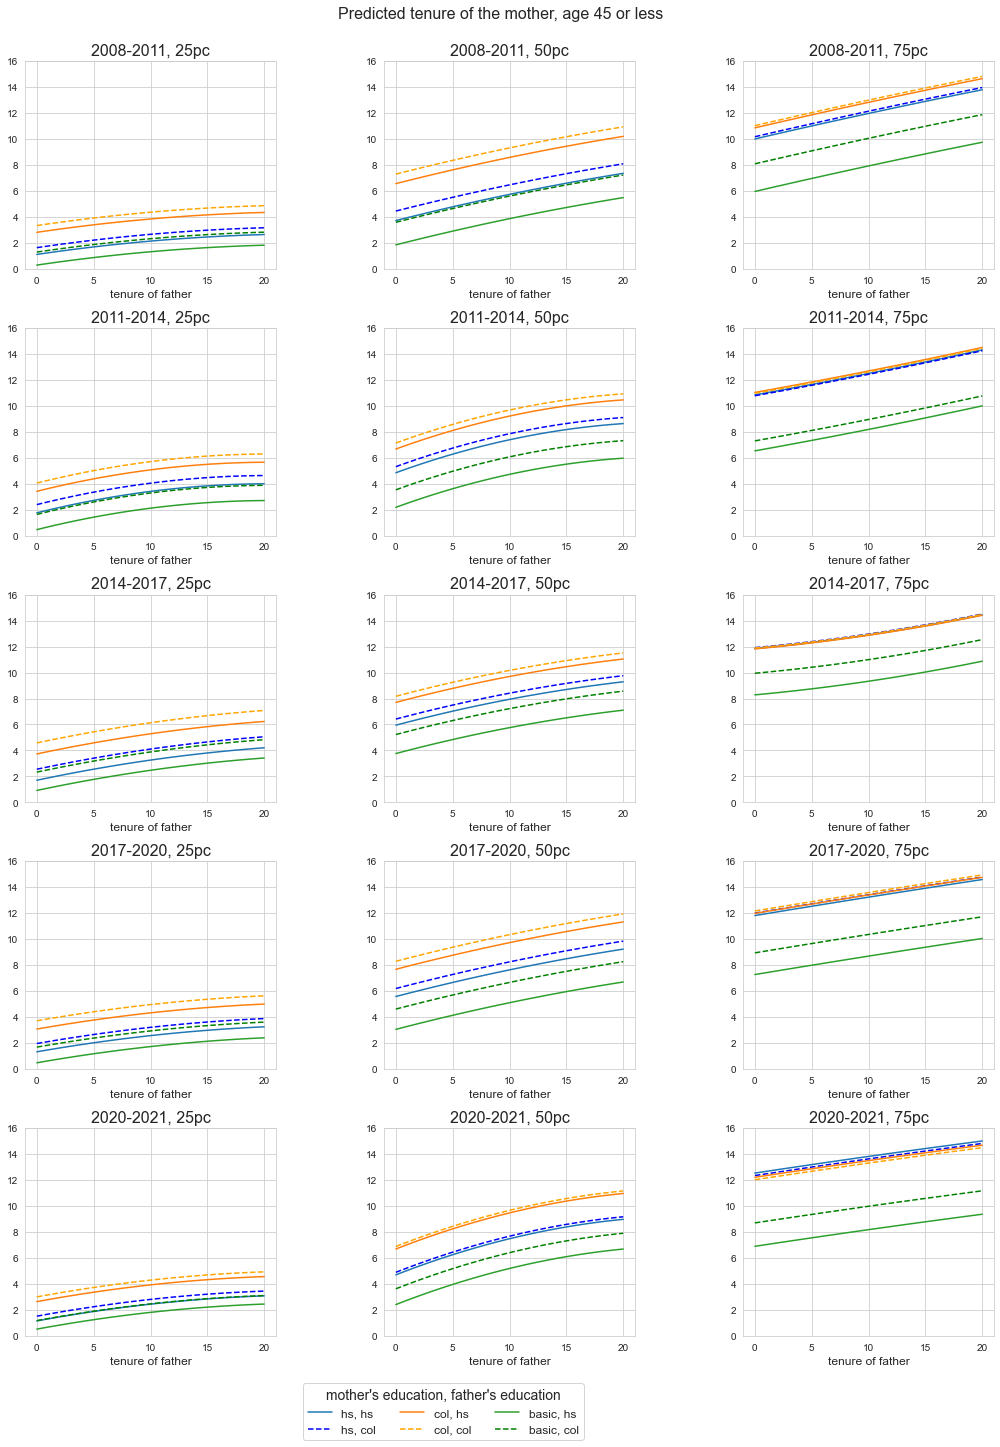

In [12]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the mother, age 45 or less',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,
                                           ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,
                                           ten_range,hub_educ='college'),label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='college',hub_educ='college'),label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='less_hs',hub_educ='college'),label='basic, col',c='g',ls='--')
    plt.xlabel('tenure of father',fontsize=12)
    plt.ylim(0,16)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,hub_educ='college'),
             label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),
             label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
             label='basic, col',c='g',ls='--')
    plt.xlabel('tenure of father',fontsize=12)
    if i==14:
        plt.legend(title="mother's education, father's education",fontsize=12,title_fontsize=14,
               ncol=3,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,16)
    i+=1

    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,hub_educ='college'),
             label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),
             label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
             label='basic, col',c='g',ls='--')
    # plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')
    plt.ylim(0,16)
    plt.xlabel('tenure of father',fontsize=12)
    
    i+=1

plt.tight_layout()
# plt.savefig('./plots_tenure/qregs_spa_all_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

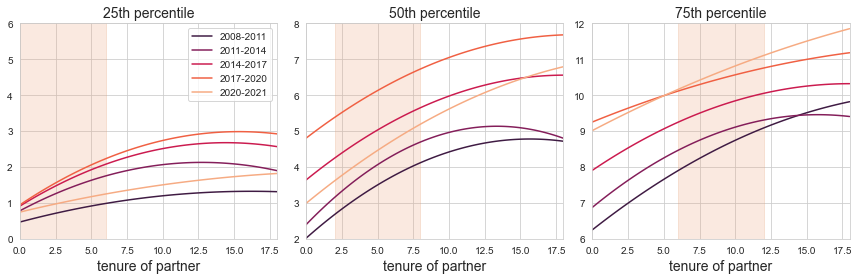

In [44]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
label_dict = dict(zip(time_periods,time_labels))
ylims = [(0,6),(2,8),(6,12)]
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==0:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_kids_HS_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

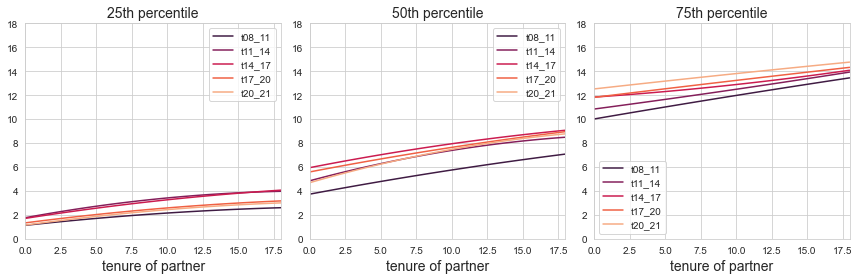

In [23]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(period),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_kids_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

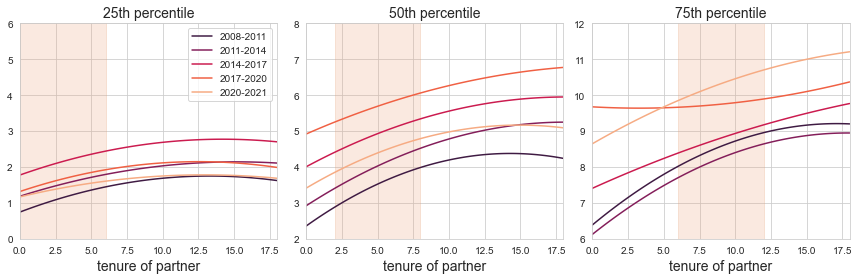

In [43]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
label_dict = dict(zip(time_periods,time_labels))
ylims = [(0,6),(2,8),(6,12)]
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==0:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_nokids_HS_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

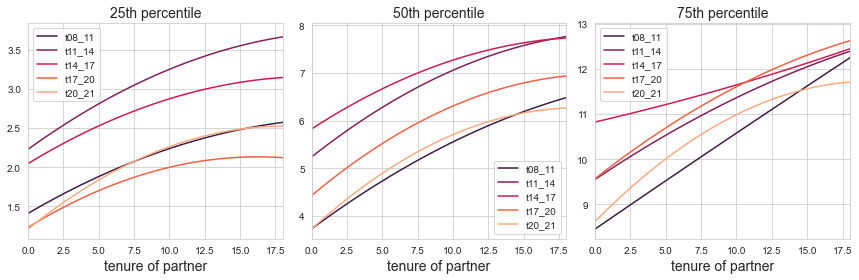

In [42]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(period),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_nokids_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

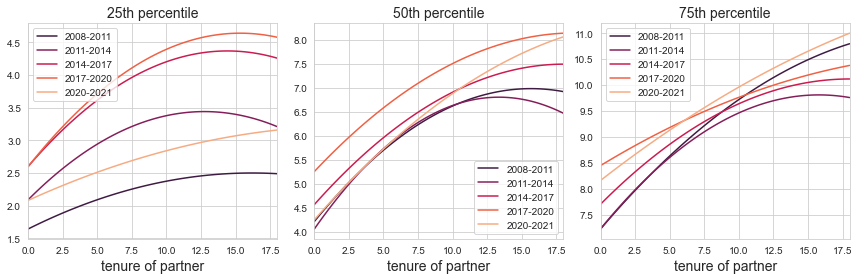

In [32]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
# plt.savefig('./plots_tenure/qregs_spa_women_kids_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

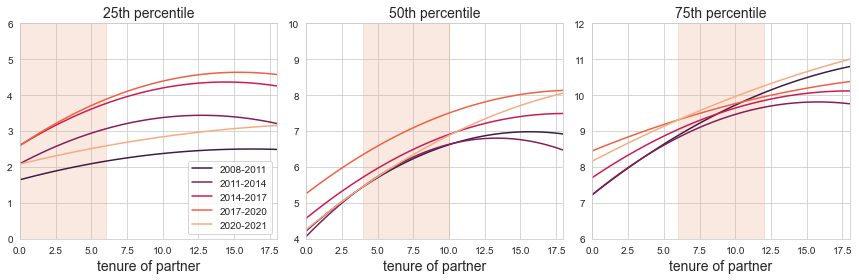

In [42]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
label_dict = dict(zip(time_periods,time_labels))
ylims = [(0,6),(4,10),(6,12)]
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==0:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_kids_college_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

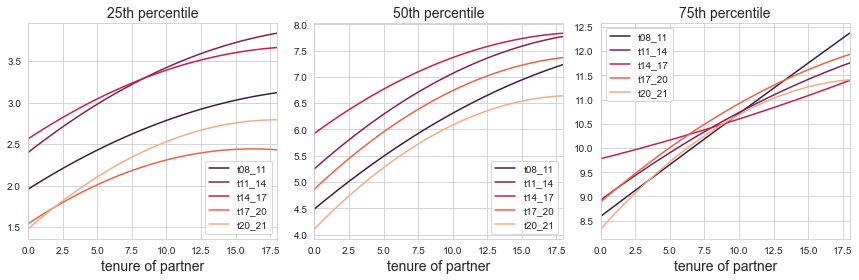

In [40]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(period),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_nokids_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

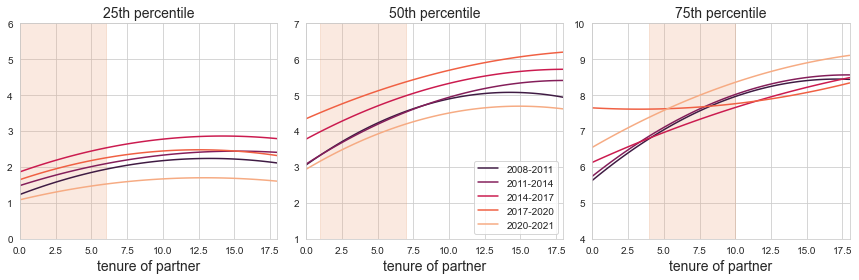

In [41]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
label_dict = dict(zip(time_periods,time_labels))
ylims = [(0,6),(1,7),(4,10)]
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==1:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_nokids_college_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

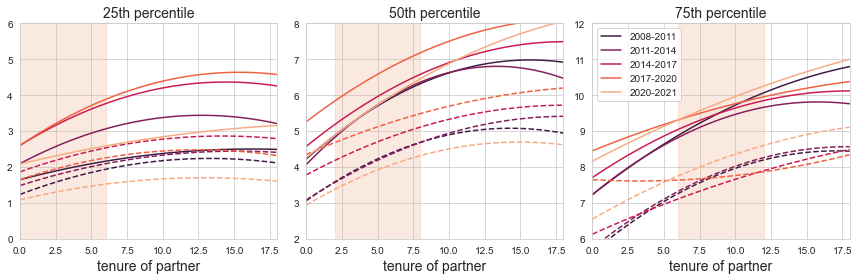

In [45]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
ylims = ((0,7.5),(4,13),(7,15))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_women(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
# plt.savefig('./plots_tenure/qregs_spa_women_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

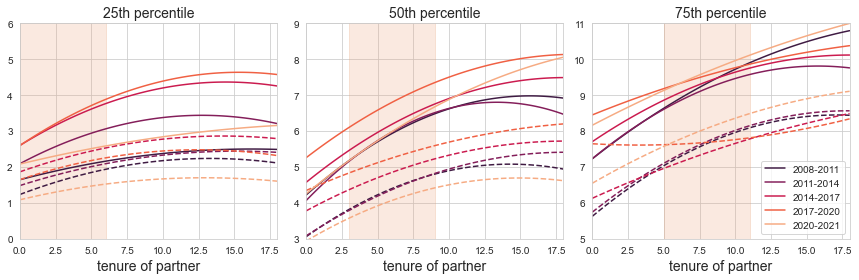

In [48]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
ylims = ((0,6),(3,9),(5,11))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_women(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_college_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

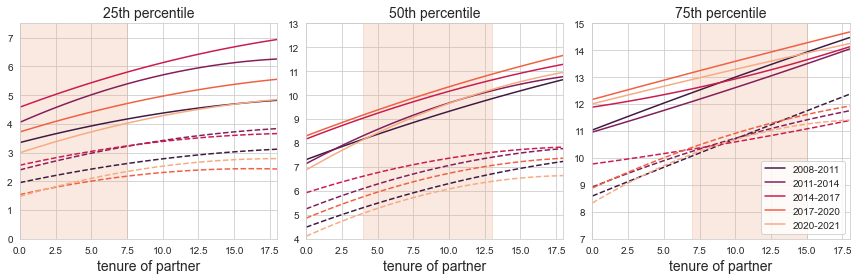

In [67]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
ylims = ((0,7.5),(4,13),(7,15))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_women(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                  educ='college',hub_educ='college'),ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

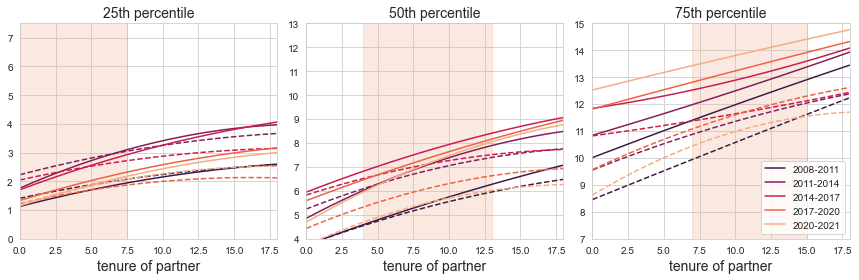

In [68]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
ylims = ((0,7.5),(4,13),(7,15))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_women(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

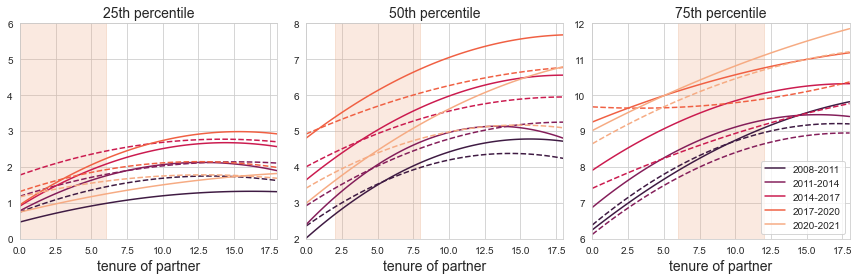

In [54]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]
datasets = [tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]
ylims = ((0,6),(2,8),(6,12))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_women(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_women(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_women_HS_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

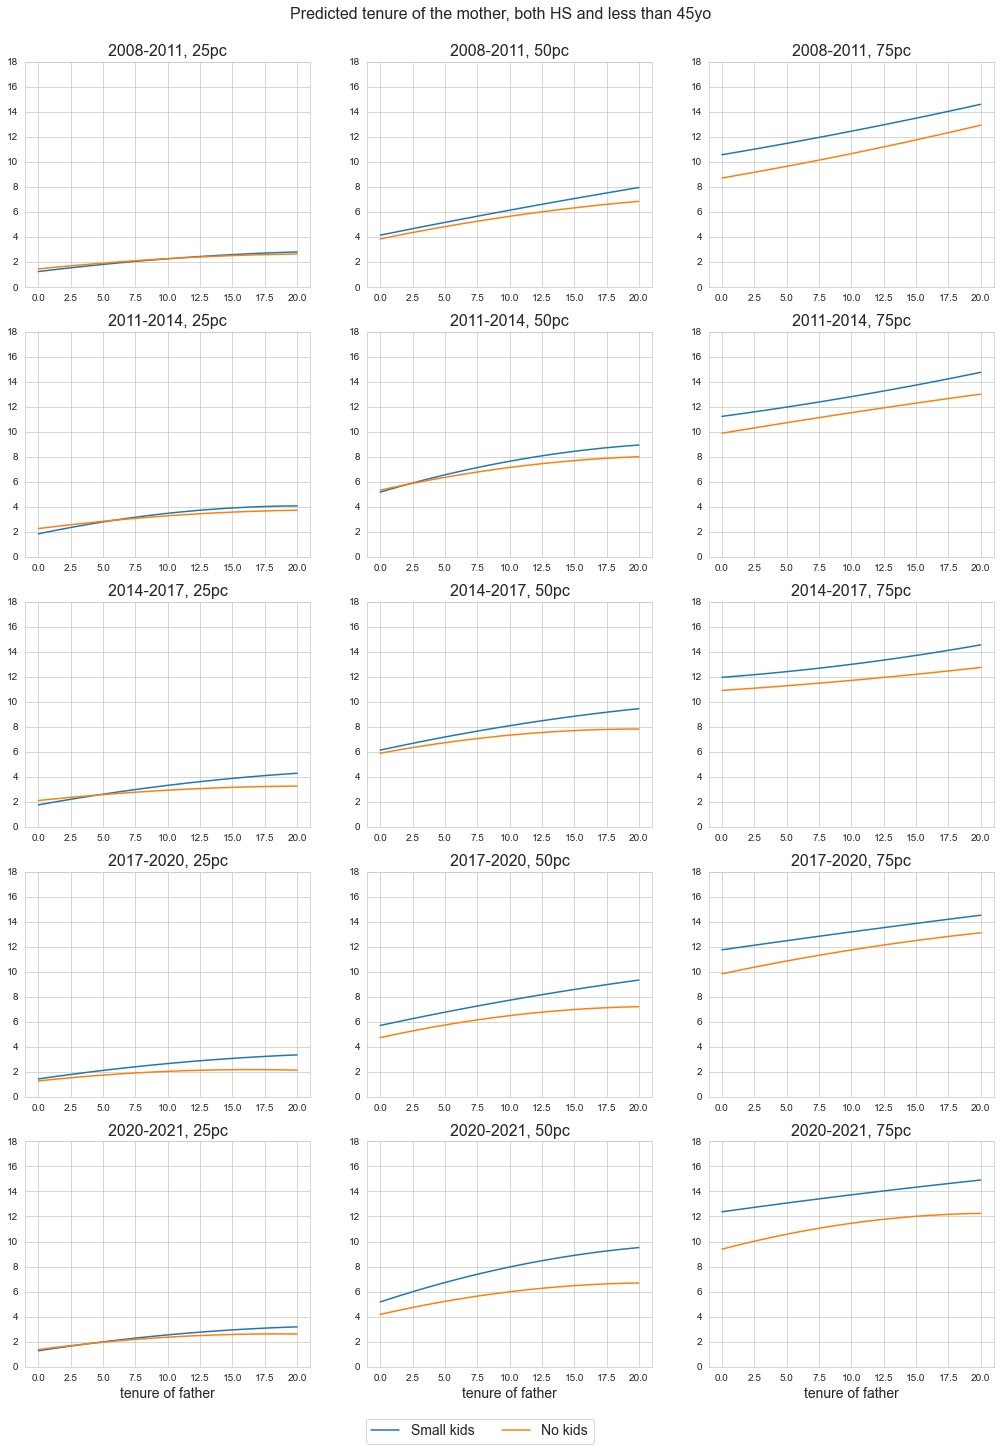

In [114]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+1:
        plt.xlabel('tenure of father',fontsize=14)
    plt.ylim(0,18)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+2:
        plt.xlabel('tenure of father',fontsize=14)
        plt.legend(fontsize=14,ncol=2,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,18)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+3:
        plt.xlabel('tenure of father',fontsize=14)
    plt.ylim(0,18)
    i+=1

plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

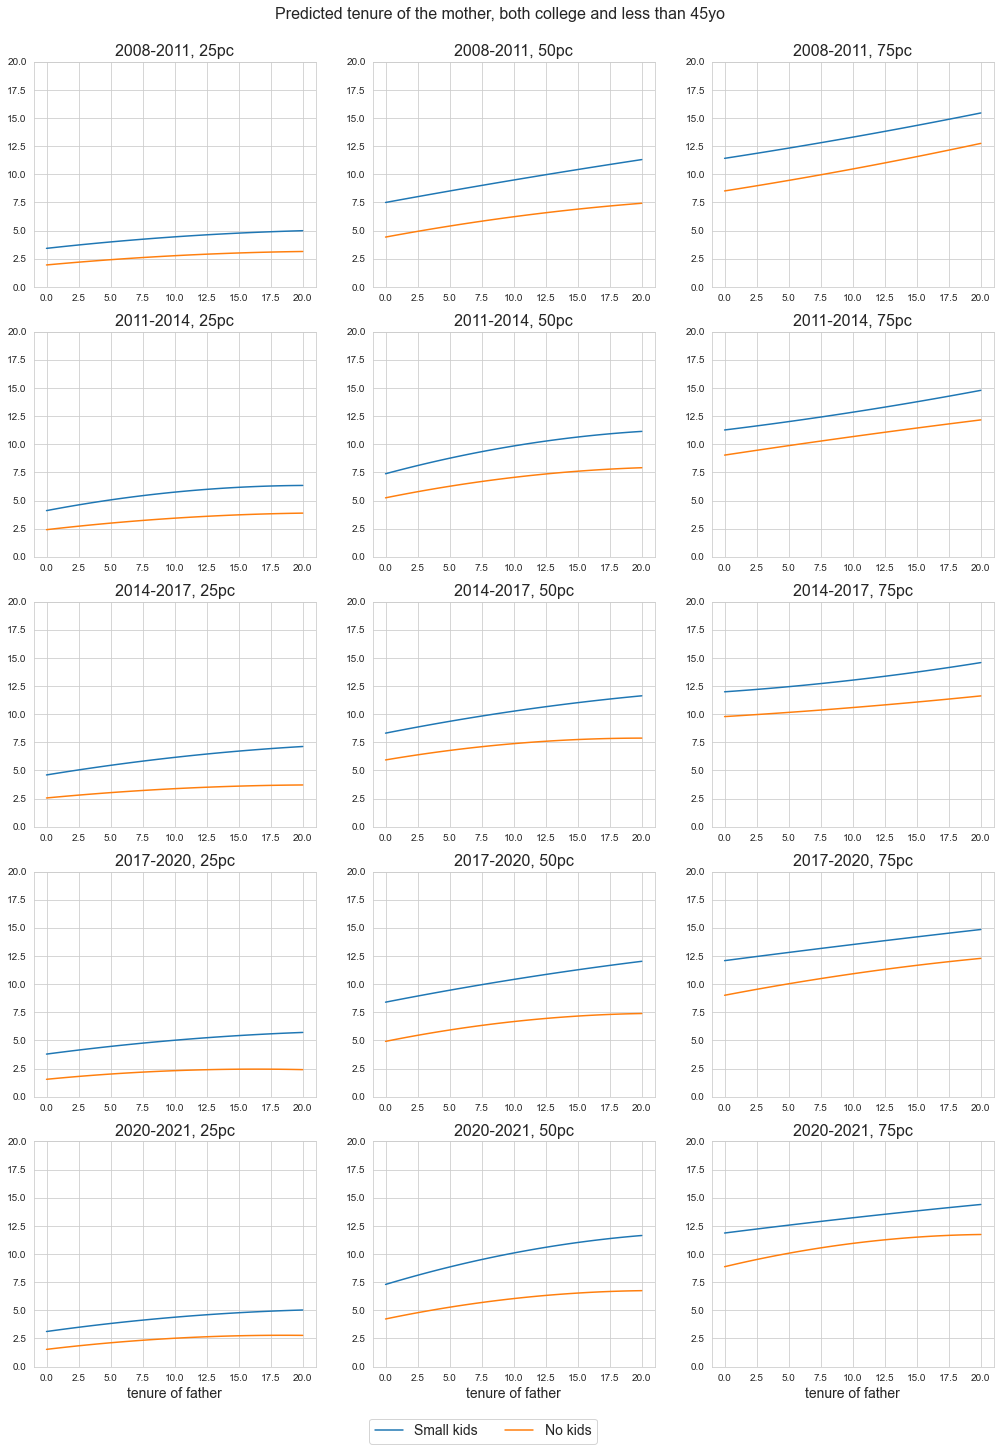

In [115]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the mother, both college and less than 45yo',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_25_0k[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+1:
        plt.xlabel('tenure of father',fontsize=14)
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_50_0k[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+2:
        plt.xlabel('tenure of father',fontsize=14)
        plt.legend(fontsize=14,ncol=2,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_women(tab_moms_45_75_0k[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+3:
        plt.xlabel('tenure of father',fontsize=14)
    plt.ylim(0,20)
    i+=1

plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [69]:
sd_50_m_45_0k = {}
sd_50_m_45 = {}

sd_25_m_45_0k = {}
sd_25_m_45 = {}

sd_75_m_45_0k = {}
sd_75_m_45 = {}

for period in (time_periods):
    sd_50_m_45_0k[period] = tab_moms_45_50_0k[period]['std']
    sd_50_m_45[period] = tab_moms_45_50[period]['std']

    sd_25_m_45_0k[period] = tab_moms_45_25_0k[period]['std']
    sd_25_m_45[period] = tab_moms_45_25[period]['std']

    sd_75_m_45_0k[period] = tab_moms_45_75_0k[period]['std']
    sd_75_m_45[period] = tab_moms_45_75[period]['std']

In [117]:
bnames = sd_50_m_45_0k["t08_11"].index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
basic_colnames = ['With kids','No kids']
C = len(basic_colnames)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)

colnames = []
for t in range(T):
    for c in range(C):
        colnames.append(time_labels[t]+", "+basic_colnames[c])

data_0k_45 = np.empty(N*2)
data_45 = np.empty(N*2)

i = 0
all_data = np.zeros((N*2))
for period in time_periods:
    i = 0
    data_0k_45 = np.empty(N*2)
    data_45 = np.empty(N*2)
    for name in bnames:

        data_0k_45[i] = tab_moms_45_50_0k[period]['Coefficient'].loc[name]
        data_45[i] = tab_moms_45_50[period]['Coefficient'].loc[name]
        i+=1
        data_0k_45[i] = sd_50_m_45_0k[period].loc[name]
        data_45[i] = sd_50_m_45[period].loc[name]
        i+=1

    all_data = np.vstack((all_data,data_45,data_0k_45))   
    
coef_table_export = pd.DataFrame(all_data[1:,:],columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    for j in range(N):
        coef_table_export.iloc[i,j]='('+str(coef_table_export.iloc[i,j])+')'

In [118]:
print(coef_table_export.to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} & 2008-2011, With kids & 2008-2011, No kids & 2011-2014, With kids & 2011-2014, No kids & 2014-2017, With kids & 2014-2017, No kids & 2017-2020, With kids & 2017-2020, No kids & 2020-2021, With kids & 2020-2021, No kids \\
\midrule
husband tenure         &                0.208 &              0.211 &                0.305 &              0.229 &                0.224 &              0.192 &                0.222 &              0.228 &                0.341 &              0.236 \\
                       &              (0.013) &            (0.016) &              (0.016) &            (0.018) &              (0.016) &            (0.021) &              (0.021) &            (0.015) &              (0.027) &            (0.021) \\
husband tenure 2       &               -0.001 &             -0.003 &               -0.006 &             -0.005 &               -0.003 &             -0.005 &               -0.002 &             -0.005 &               -0.006 &            

In [121]:
bnames = sd_25_m_45_0k["t08_11"].index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
basic_colnames = ['With kids','No kids']
C = len(basic_colnames)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)

colnames = []
for t in range(T):
    for c in range(C):
        colnames.append(time_labels[t]+", "+basic_colnames[c])

data_0k_45 = np.empty(N*2)
data_45 = np.empty(N*2)

i = 0
all_data = np.zeros((N*2))
for period in time_periods:
    i = 0
    data_0k_45 = np.empty(N*2)
    data_45 = np.empty(N*2)
    for name in bnames:

        data_0k_45[i] = tab_moms_45_25_0k[period]['Coefficient'].loc[name]
        data_45[i] = tab_moms_45_50[period]['Coefficient'].loc[name]
        i+=1
        data_0k_45[i] = sd_25_m_45_0k[period].loc[name]
        data_45[i] = sd_25_m_45[period].loc[name]
        i+=1

    all_data = np.vstack((all_data,data_45,data_0k_45))   
    
coef_table_export_25 = pd.DataFrame(all_data[1:,:],columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    for j in range(N):
        coef_table_export_25.iloc[i,j]='('+str(coef_table_export_25.iloc[i,j])+')'

In [95]:
print(coef_table_export_25.to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} & 2008-2011, With kids & 2008-2011, No kids & 2011-2014, With kids & 2011-2014, No kids & 2014-2017, With kids & 2014-2017, No kids & 2017-2020, With kids & 2017-2020, No kids & 2020-2021, With kids & 2020-2021, No kids \\
\midrule
husband tenure         &                0.208 &              0.104 &                0.305 &              0.131 &                0.224 &              0.107 &                0.222 &               0.11 &                0.341 &              0.135 \\
                       &               (0.01) &            (0.012) &              (0.013) &            (0.009) &              (0.018) &            (0.014) &              (0.012) &            (0.009) &               (0.02) &            (0.017) \\
husband tenure 2       &               -0.001 &             -0.002 &               -0.006 &             -0.003 &               -0.003 &             -0.002 &               -0.002 &             -0.003 &               -0.006 &            

In [96]:
bnames = sd_75_m_45_0k["t08_11"].index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
basic_colnames = ['With kids','No kids']
C = len(basic_colnames)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)

colnames = []
for t in range(T):
    for c in range(C):
        colnames.append(time_labels[t]+", "+basic_colnames[c])

data_0k_45 = np.empty(N*2)
data_45 = np.empty(N*2)

i = 0
all_data = np.zeros((N*2))
for period in time_periods:
    i = 0
    data_0k_45 = np.empty(N*2)
    data_45 = np.empty(N*2)
    for name in bnames:

        data_0k_45[i] = tab_moms_45_75_0k[period]['Coefficient'].loc[name]
        data_45[i] = tab_moms_45_50[period]['Coefficient'].loc[name]
        i+=1
        data_0k_45[i] = sd_75_m_45_0k[period].loc[name]
        data_45[i] = sd_75_m_45[period].loc[name]
        i+=1

    all_data = np.vstack((all_data,data_45,data_0k_45))   
    
coef_table_export_75 = pd.DataFrame(all_data[1:,:],columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    for j in range(N):
        coef_table_export_75.iloc[i,j]='('+str(coef_table_export_75.iloc[i,j])+')'

In [97]:
print(coef_table_export_75.to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} & 2008-2011, With kids & 2008-2011, No kids & 2011-2014, With kids & 2011-2014, No kids & 2014-2017, With kids & 2014-2017, No kids & 2017-2020, With kids & 2017-2020, No kids & 2020-2021, With kids & 2020-2021, No kids \\
\midrule
husband tenure         &                0.208 &              0.179 &                0.305 &              0.172 &                0.224 &              0.069 &                0.222 &              0.218 &                0.341 &              0.271 \\
                       &              (0.016) &            (0.015) &              (0.014) &            (0.022) &              (0.019) &            (0.022) &              (0.014) &            (0.028) &               (0.02) &            (0.046) \\
husband tenure 2       &               -0.001 &              0.002 &               -0.006 &             -0.001 &               -0.003 &              0.001 &               -0.002 &             -0.003 &               -0.006 &            

<a id='urgh'></a>

### Men

Jump to
 - [Women](#index)
 --------------

In [55]:
def predicted_ten_men(coef_series,descriptive_table,ten_range,age_at_mean=None,
                      educ=None,part_time=False,hub_educ=None):
    av_age_da_05 = descriptive_table['Age_father'][0]
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    b_ten_hub = coef_series.loc['wife_ten_y']
    b_ten2_hub = coef_series.loc['wife_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['wife_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['wife_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
#     predicted_ten =  coef_series.loc['_cons'] + coef_series.loc['age']*av_age_da_05 + \
#              coef_series.loc['wife_age']*av_age_mo_05 + \
#             ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    predicted_ten =  coef_series.loc['_cons'] + coef_series.loc['wife_age']*av_age_mo_05 + \
            ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

In [79]:
# tab_dads_45_25 = {}
# tab_dads_45_50 = {}
# tab_dads_45_75 = {}

# tab_dads_45_25_0k = {}
# tab_dads_45_50_0k = {}
# tab_dads_45_75_0k = {}

# for period in time_periods:
#     tab_dads_45_25[period] = read_table(path+'sqtreg_fathers_45_{}_1.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
#     tab_dads_45_50[period] = read_table(path+'sqtreg_fathers_45_{}_2.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
#     tab_dads_45_75[period] = read_table(path+'sqtreg_fathers_45_{}_3.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
#     tab_dads_45_25_0k[period] = read_table(path+'sqtreg_fathers_0k_45_{}_1.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
#     tab_dads_45_50_0k[period] = read_table(path+'sqtreg_fathers_0k_45_{}_2.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
#     tab_dads_45_75_0k[period] = read_table(path+'sqtreg_fathers_0k_45_{}_3.log'.format(period),
#                          keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])


In [60]:
tab_dads_45_25 = {}
tab_dads_45_50 = {}
tab_dads_45_75 = {}

tab_dads_45_25_0k = {}
tab_dads_45_50_0k = {}
tab_dads_45_75_0k = {}

for ip,period in enumerate(time_periods):
    tab_dads_45_25[period] = read_table(path+'sqtreg_fathers_3035_{}_1.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
    tab_dads_45_50[period] = read_table(path+'sqtreg_fathers_3035_{}_2.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
    tab_dads_45_75[period] = read_table(path+'sqtreg_fathers_3035_{}_3.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
    tab_dads_45_25_0k[period] = read_table(path+'sqtreg_fathers_0k_3035_{}_1.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
    tab_dads_45_50_0k[period] = read_table(path+'sqtreg_fathers_0k_3035_{}_2.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])
    tab_dads_45_75_0k[period] = read_table(path+'sqtreg_fathers_0k_3035_{}_3.log'.format(ip+1),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False,omit_list=['age2'])


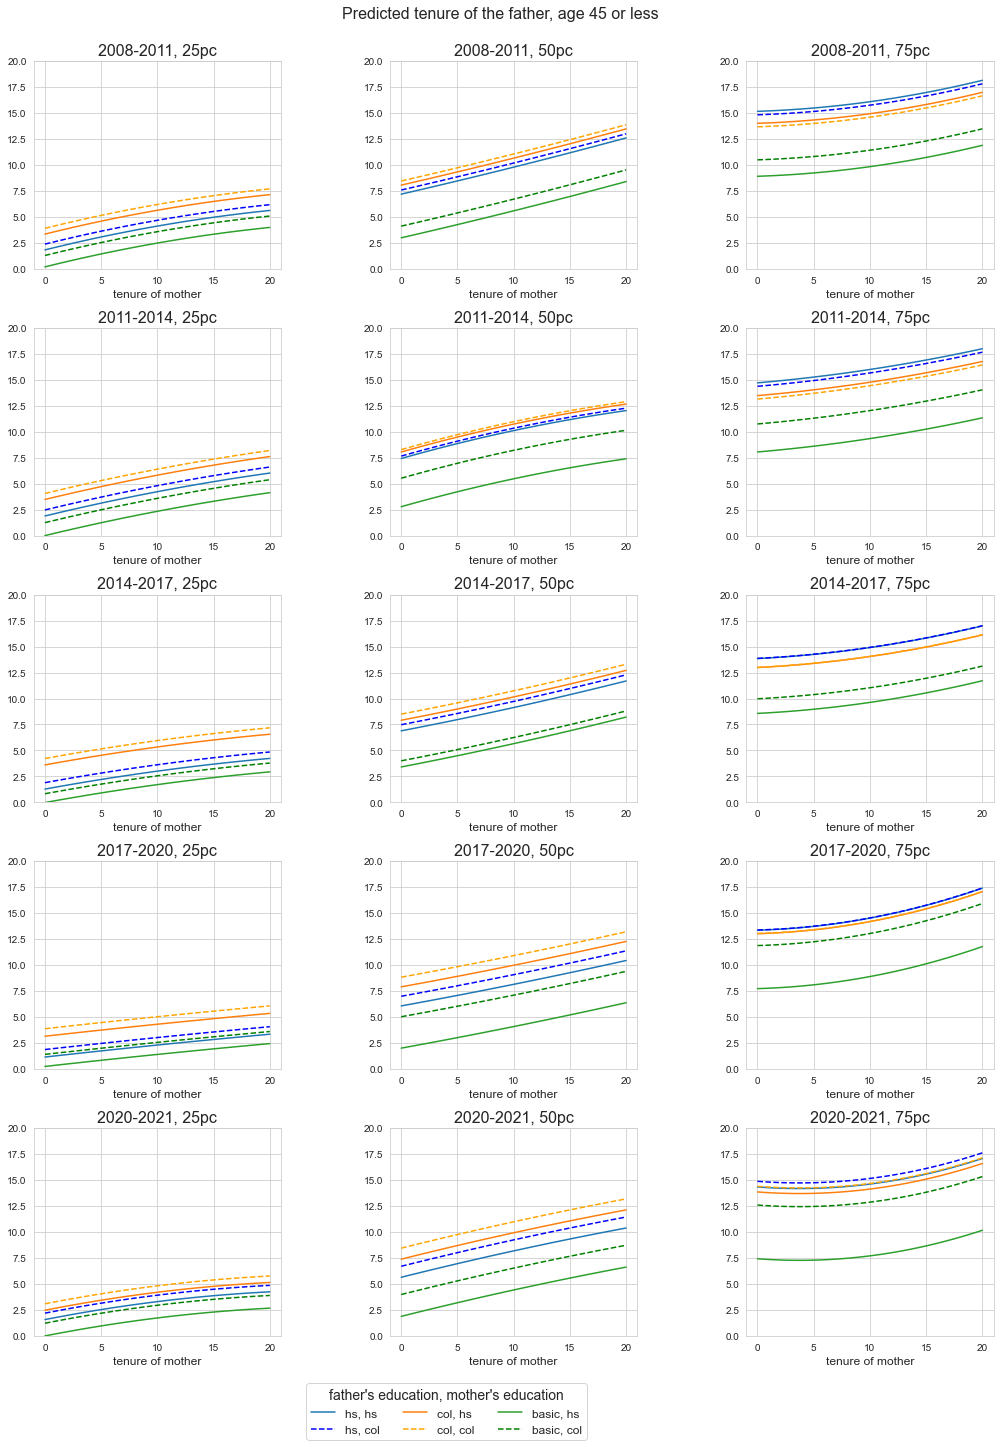

In [83]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the father, age 45 or less',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,
                                           ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,
                                           ten_range,hub_educ='college'),label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='college',hub_educ='college'),label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                           educ='less_hs',hub_educ='college'),label='basic, col',c='g',ls='--')
    plt.xlabel('tenure of mother',fontsize=12)
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,hub_educ='college'),
             label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),
             label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
             label='basic, col',c='g',ls='--')
    plt.xlabel('tenure of mother',fontsize=12)
    if i==14:
        plt.legend(title="father's education, mother's education",fontsize=12,title_fontsize=14,
               ncol=3,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,20)
    i+=1

    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range),label='hs, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,hub_educ='college'),
             label='hs, col',c='blue',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='college'),label='col, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='college',hub_educ='college'),
             label='col, col',c='orange',ls='--')

    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
             label='basic, col',c='g',ls='--')
    # plt.axvline(descrip_stats['Tenure_mother'][0]/12,ls='-.',lw=0.75,c='r')
    plt.ylim(0,20)
    plt.xlabel('tenure of mother',fontsize=12)
    
    i+=1

plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_all_dads_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

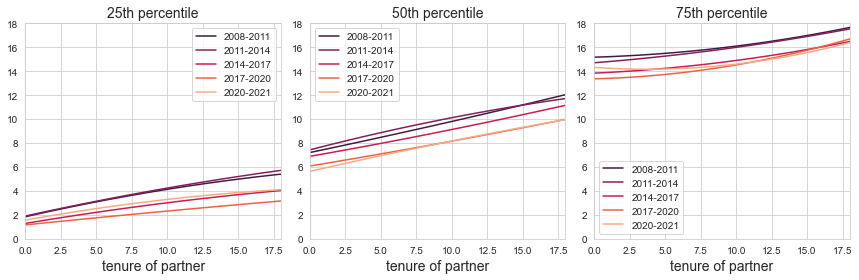

In [91]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_kids_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

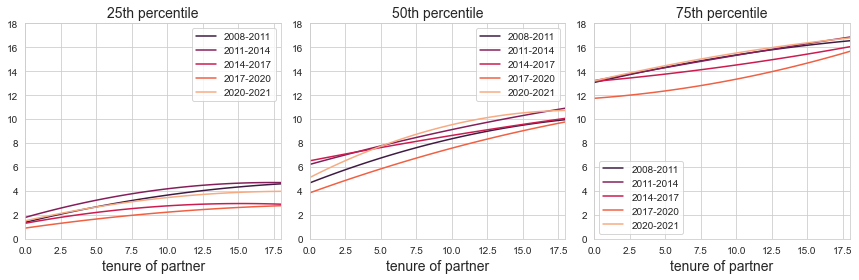

In [89]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets = [tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
            plt.ylim(0,18)
            plt.xlim(0,18)
            plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_nokids_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

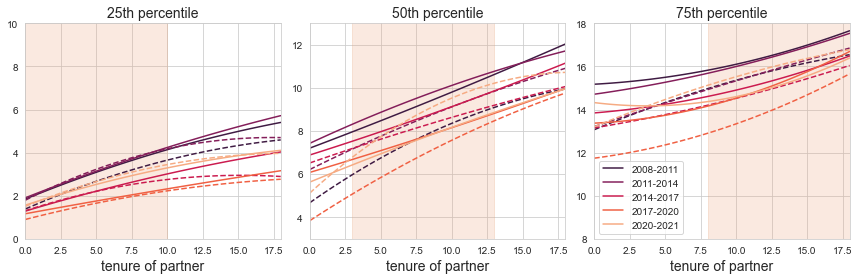

In [103]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]
datasets = [tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]
ylims = ((0,10),(3,13),(8,18))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_men(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_HS_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

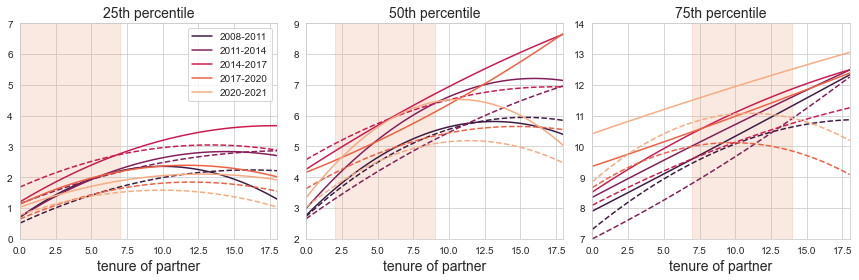

In [64]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]
datasets = [tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]
ylims = ((0,7),(2,9),(7,14))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_men(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
            plt.xlim(0,18)
            if iq==0:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_HS_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

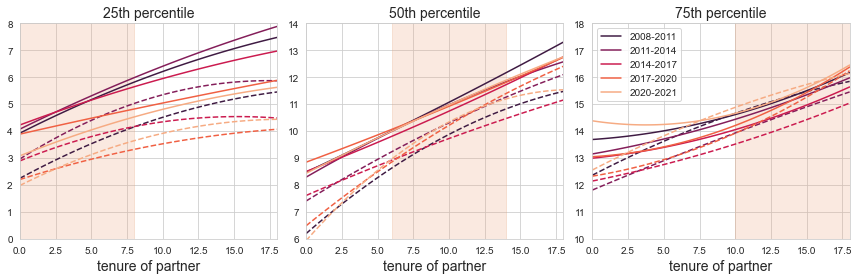

In [101]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]
datasets = [tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]
ylims = ((0,8),(6,14),(10,18))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_men(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                educ='college',hub_educ='college'),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
#             plt.ylim(0,18)
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_college_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

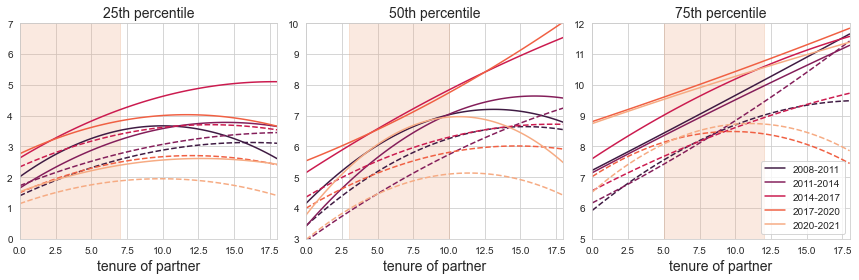

In [69]:
ten_range = np.linspace(0,18,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
datasets_0k = [tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]
datasets = [tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]
ylims = ((0,7),(3,10),(5,12))
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

with sn.color_palette('rocket',T):
    colors = sn.color_palette()
    plt.figure(figsize=(12,4))
#     plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1)
    for iq,q in enumerate([25,50,75]):
        plt.subplot(131+iq)
        plt.title('{}th percentile'.format(q),fontsize=14)
        for ip,period in enumerate(time_periods):
            plt.plot(ten_range,predicted_ten_men(datasets[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                educ='college',hub_educ='college'),
                     label='{}'.format(label_dict[period]),c=colors[ip])
            plt.plot(ten_range,predicted_ten_men(datasets_0k[iq][period]['Coefficient'],descrip_stats,ten_range,
                                                educ='college',hub_educ='college'),
                     ls='--',c=colors[ip])
            plt.xlabel('tenure of partner',fontsize=14)
#             plt.fill_between((0,1),-1,0.5,alpha=0.2,color='grey')
            plt.fill_betweenx((0,20),ylims[iq][0],ylims[iq][1],color=colors[T-1],alpha=0.05)
            plt.ylim(ylims[iq])
#             plt.ylim(0,18)
            plt.xlim(0,18)
            if iq==2:
                plt.legend()
        
plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_men_college_3035_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

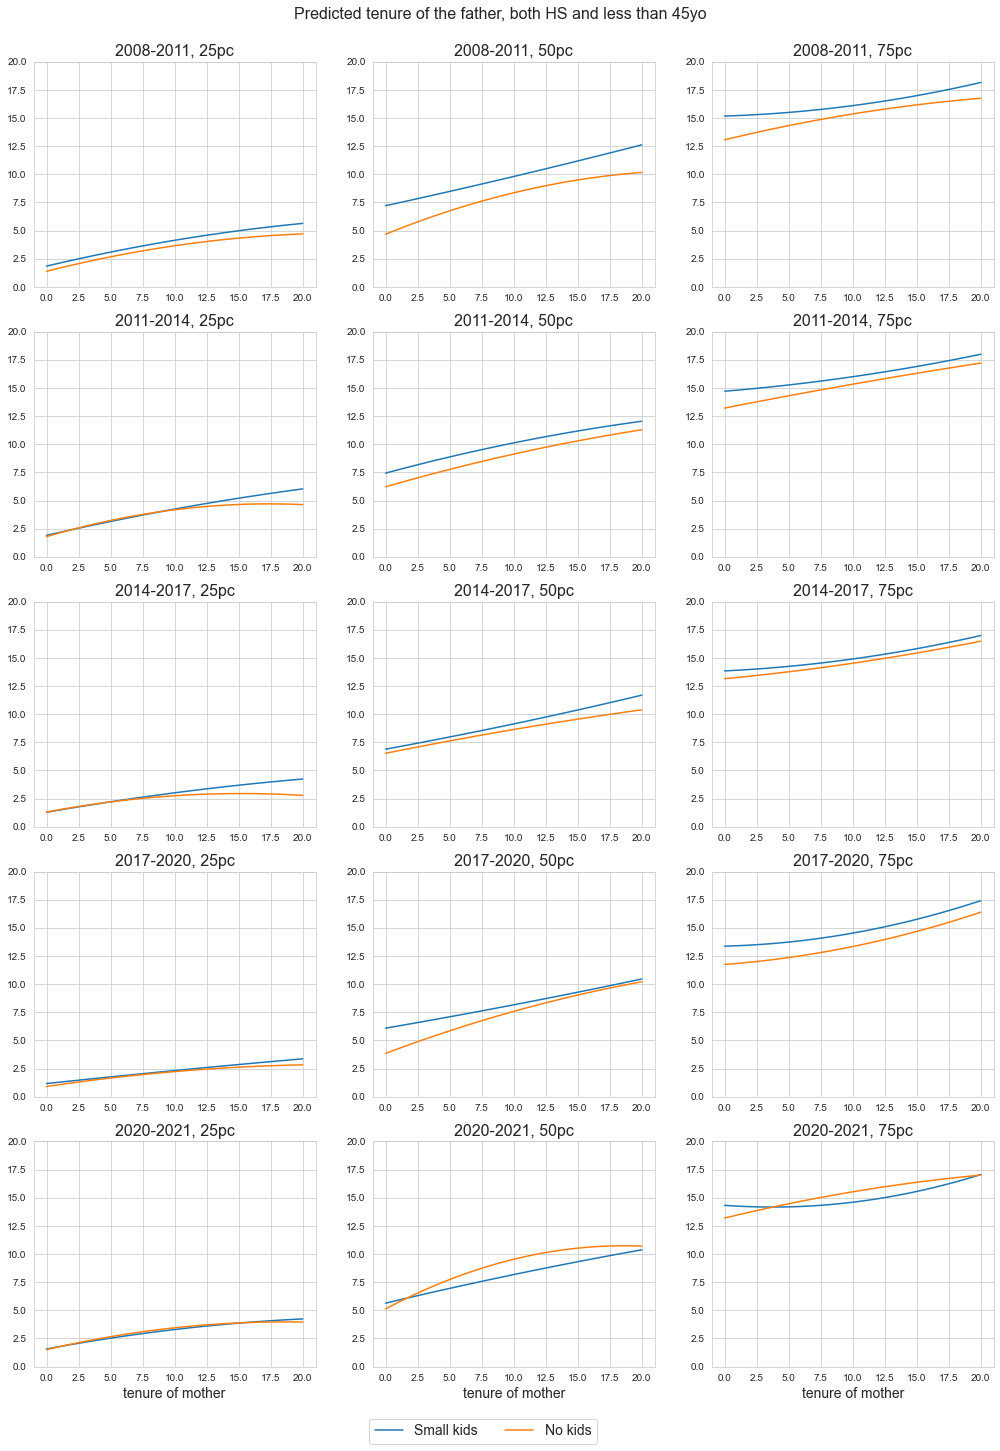

In [107]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the father, both HS and less than 45yo',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+1:
        plt.xlabel('tenure of mother',fontsize=14)
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+2:
        plt.xlabel('tenure of mother',fontsize=14)
        plt.legend(fontsize=14,ncol=2,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75_0k[period]['Coefficient'],descrip_stats,ten_range),label='No kids')
    if i==(T-1)*3+3:
        plt.xlabel('tenure of mother',fontsize=14)
    plt.ylim(0,20)
    i+=1

plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_HS_dads_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

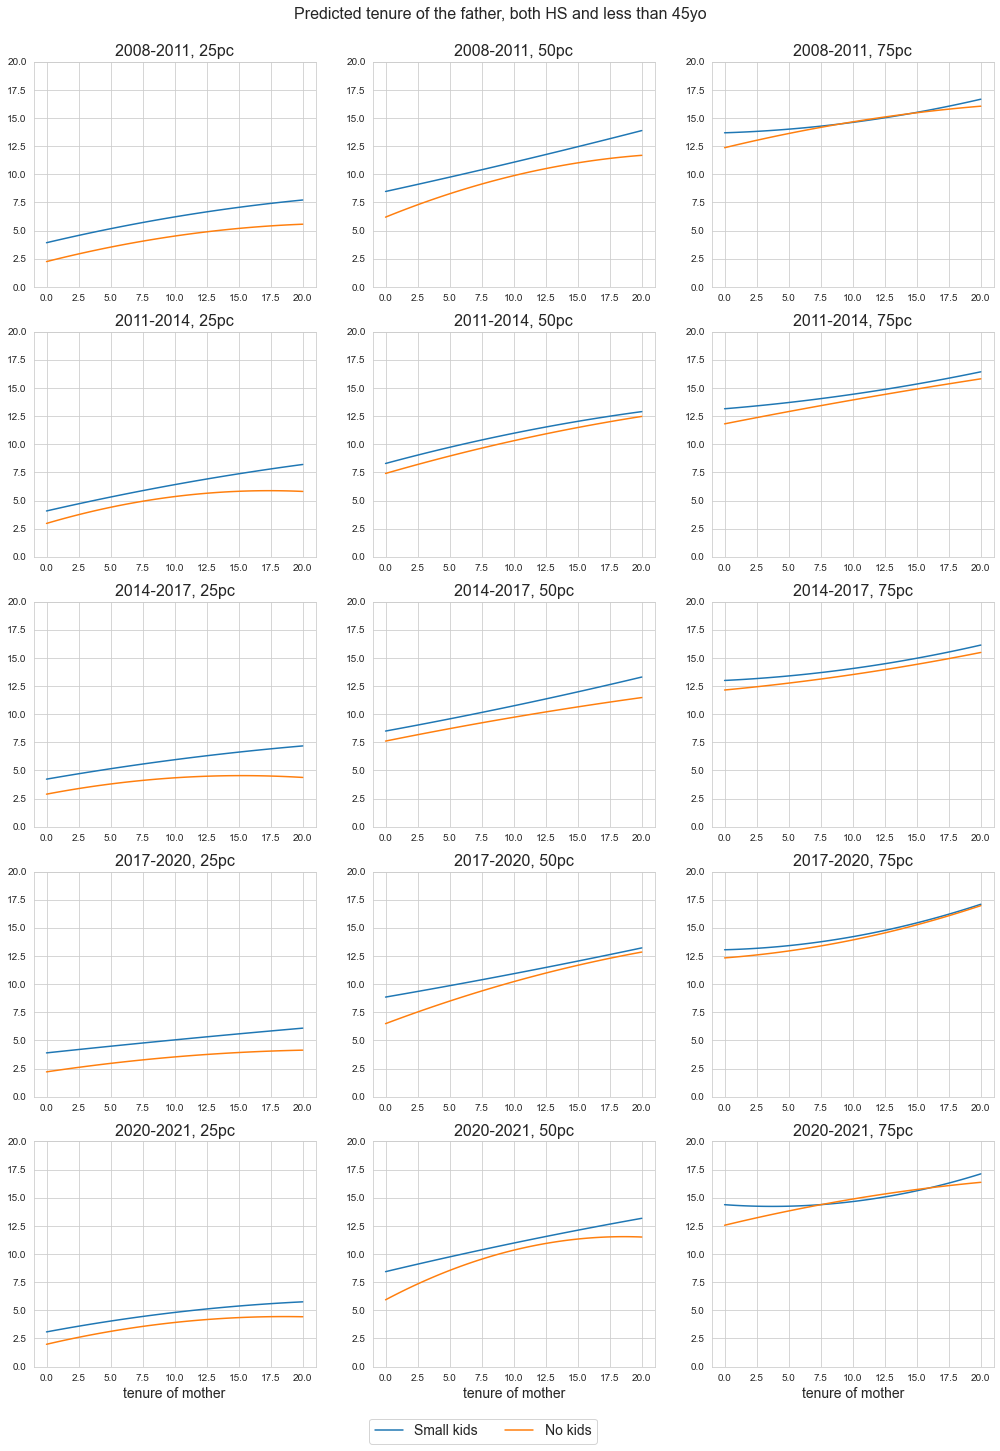

In [109]:
ten_range = np.linspace(0,20,100)
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20_21"]
time_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020-2021']
label_dict = dict(zip(time_periods,time_labels))
T = len(time_periods)
i = 1

plt.figure(figsize=(14,4*T))
plt.suptitle('Predicted tenure of the father, both HS and less than 45yo',fontsize=16,y=1)
for period in (time_periods):
    plt.subplot(T,3,i)
    plt.title('{}, 25pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25[period]['Coefficient'],descrip_stats,ten_range,
                                         educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_25_0k[period]['Coefficient'],descrip_stats,ten_range,
                                        educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+1:
        plt.xlabel('tenure of mother',fontsize=14)
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 50pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50[period]['Coefficient'],descrip_stats,ten_range,
                                        educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_50_0k[period]['Coefficient'],descrip_stats,ten_range,
                                        educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+2:
        plt.xlabel('tenure of mother',fontsize=14)
        plt.legend(fontsize=14,ncol=2,bbox_to_anchor=(0.82,-0.2))
    plt.ylim(0,20)
    i+=1
    
    plt.subplot(T,3,i)
    plt.title('{}, 75pc'.format(label_dict[period]),fontsize=16)
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75[period]['Coefficient'],descrip_stats,ten_range,
                                        educ='college',hub_educ='college'),label='Small kids')
    plt.plot(ten_range,predicted_ten_men(tab_dads_45_75_0k[period]['Coefficient'],descrip_stats,ten_range,
                                        educ='college',hub_educ='college'),label='No kids')
    if i==(T-1)*3+3:
        plt.xlabel('tenure of mother',fontsize=14)
    plt.ylim(0,20)
    i+=1

plt.tight_layout()
plt.savefig('./plots_tenure/qregs_spa_college_dads_45_time.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [34]:
descrip_stats

,index,Tenure_mother,Tenure_father,Tenure_mother_PC,Tenure_father_PC,Participation_mother,Participation_father,Employment_mother,Employment_father,Unemployment_mother,Unemployment_father,Age_mother,Age_father,Hours_mother,Hours_father,dates
0,130,91.09012,116.9287,127.9036,141.4162,0.633599,0.961774,0.450439,0.709365,0.147943,0.044601,35.20958,37.41877,28.671940,38.063430,2005Q1
1,131,89.06780,115.4223,126.7102,143.1194,0.635941,0.963031,0.462568,0.724105,0.129352,0.036813,35.20274,37.49490,29.851419,40.176169,2005Q2
2,132,89.37599,114.5817,125.6732,140.4082,0.633274,0.960994,0.469644,0.723078,0.115090,0.038163,35.21030,37.48182,28.971241,38.834750,2005Q3
3,133,90.05831,114.4557,129.0288,141.2429,0.649908,0.961877,0.478113,0.719393,0.125371,0.037142,35.22358,37.49816,29.290787,39.165262,2005Q4
4,134,91.16219,116.4211,130.2905,146.4587,0.659418,0.962015,0.483887,0.715218,0.130488,0.039579,35.29366,37.62405,29.797640,39.625940,2006Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,193,111.58080,125.1961,139.5246,146.7777,0.812523,0.954835,0.587577,0.705015,0.180266,0.078425,38.19639,40.31597,29.603744,36.326162,2020Q4
64,194,116.03410,131.8757,139.5533,149.7803,0.814278,0.949276,0.588652,0.699881,0.176658,0.080463,38.55468,40.47890,27.780260,34.619440,2021Q1
65,195,113.27630,128.4572,138.7459,146.1301,0.821331,0.957396,0.599467,0.712823,0.164208,0.070140,38.59576,40.54585,31.130821,38.005726,2021Q2
66,196,112.86080,128.3862,139.8803,146.5570,0.817427,0.959945,0.605297,0.714653,0.152793,0.077505,38.72406,40.67633,28.817812,34.794831,2021Q3
